# Sentimenet analysis of major US airlines tweets

*"If we cannot beat our competitors, we beat our passengers."* - an anonymous airline CEO

In [262]:
# Import packages
import re
import pandas as pd 
import numpy as np
from nltk.stem.porter import *
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline
pd.options.mode.chained_assignment = None

## 1. Problem statement

The objective of this exercise is to detect positive or negative sentiments in tweets regarding US Airlines. We want to **build a classifiction model that classifies negative tweets from positive tweets**.
</br>

We will use a logistic regression model. We will use F1-score as the evaluation metric.
</br>

Let's load our data and perform a quick eye-check:

In [263]:
# load tweets data
cols = ['tweet_id', 'airline_sentiment', 'negativereason', 'airline', 'text']
data_df = pd.read_csv(r'C:\Users\leejak\Desktop\twitter sentiment analysis\twitter-airline-sentiment\Tweets.csv', usecols=cols)

In [264]:
# Basic information
data_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 5 columns):
tweet_id             14640 non-null int64
airline_sentiment    14640 non-null object
negativereason       9178 non-null object
airline              14640 non-null object
text                 14640 non-null object
dtypes: int64(1), object(4)
memory usage: 572.0+ KB


In [265]:
# First five rows of dataset
data_df.head()

,tweet_id,airline_sentiment,negativereason,airline,text
0,570306133677760513,neutral,NaN,Virgin America,@VirginAmerica What @dhepburn said.
1,570301130888122368,positive,NaN,Virgin America,@VirginAmerica plus you've added commercials t...
2,570301083672813571,neutral,NaN,Virgin America,@VirginAmerica I didn't today... Must mean I n...
3,570301031407624196,negative,Bad Flight,Virgin America,@VirginAmerica it's really aggressive to blast...
4,570300817074462722,negative,Can't Tell,Virgin America,@VirginAmerica and it's a really big bad thing...


-> Based on our initial look, we make the following observations about our dataset:
- There are 14,640 tweets; each tweet has a unique `tweet_id` (unique key)
- `airline_sentiment` is the label we want to predict; a tweet can be either 'positive', 'negative', or 'neutral'
- `negativereason` is an additional label for 'negative' tweets
- `airline` is the Airline company to which the tweet is addressed
- `text` contains the tweet

## 2. Data cleaning
In this step, we will preprocess the raw texts (tweets) to bring them into a form that is predictable and analyzable.

### 2.1 Remove Twitter handles (@)

In [266]:
# Helper function to remove 'pattern' text from 'input' text
def remove_pattern(input_text, pattern):
    r = re.findall(pattern, input_text)
    for i in r:
        input_text = re.sub(i, '', input_text)
    return input_text

# Remove twitter handles (@user)
data_df['processed_text'] = np.vectorize(remove_pattern)(data_df['text'], "@[\w]*")
data_df.head()

,tweet_id,airline_sentiment,negativereason,airline,text,processed_text
0,570306133677760513,neutral,NaN,Virgin America,@VirginAmerica What @dhepburn said.,What said.
1,570301130888122368,positive,NaN,Virgin America,@VirginAmerica plus you've added commercials t...,plus you've added commercials to the experien...
2,570301083672813571,neutral,NaN,Virgin America,@VirginAmerica I didn't today... Must mean I n...,I didn't today... Must mean I need to take an...
3,570301031407624196,negative,Bad Flight,Virgin America,@VirginAmerica it's really aggressive to blast...,"it's really aggressive to blast obnoxious ""en..."
4,570300817074462722,negative,Can't Tell,Virgin America,@VirginAmerica and it's a really big bad thing...,and it's a really big bad thing about it


### 2.2 Remove punctuations, numbers, and special characters

In [267]:
# Remove special characters, numbers, and punctuations
data_df['processed_text'] = data_df['processed_text'].str.replace("[^a-zA-Z#]", " ")
data_df.head()

,tweet_id,airline_sentiment,negativereason,airline,text,processed_text
0,570306133677760513,neutral,NaN,Virgin America,@VirginAmerica What @dhepburn said.,What said
1,570301130888122368,positive,NaN,Virgin America,@VirginAmerica plus you've added commercials t...,plus you ve added commercials to the experien...
2,570301083672813571,neutral,NaN,Virgin America,@VirginAmerica I didn't today... Must mean I n...,I didn t today Must mean I need to take an...
3,570301031407624196,negative,Bad Flight,Virgin America,@VirginAmerica it's really aggressive to blast...,it s really aggressive to blast obnoxious en...
4,570300817074462722,negative,Can't Tell,Virgin America,@VirginAmerica and it's a really big bad thing...,and it s a really big bad thing about it


### 2.3 Remove Short Words
Let's remove all words having length of 3 or less (ex: 'the', 'and', 'oh', etc..).

In [268]:
# Remove words for which len(word) <= 3
data_df['processed_text'] = data_df['processed_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
data_df.head()

,tweet_id,airline_sentiment,negativereason,airline,text,processed_text
0,570306133677760513,neutral,NaN,Virgin America,@VirginAmerica What @dhepburn said.,What said
1,570301130888122368,positive,NaN,Virgin America,@VirginAmerica plus you've added commercials t...,plus added commercials experience tacky
2,570301083672813571,neutral,NaN,Virgin America,@VirginAmerica I didn't today... Must mean I n...,didn today Must mean need take another trip
3,570301031407624196,negative,Bad Flight,Virgin America,@VirginAmerica it's really aggressive to blast...,really aggressive blast obnoxious entertainmen...
4,570300817074462722,negative,Can't Tell,Virgin America,@VirginAmerica and it's a really big bad thing...,really thing about


-> We observe that in the 5th row, the word 'bad' has been removed during this step. This is unfortunate because I believe the word 'bad' is highly correlated with a negative sentiment. Nevertheless, let's proceed.

### 2.4 Stemming
Stemming is the process of stripping suffixes ('ing', 'ly', 's', etc...) from words. For example, words such as 'loves', 'loving', and 'lovable' are often used in the same context as the word 'love'. If we can reduce them to their root word, we can reduce the total number of unique words in our dataset and avoid the risk of losing a significant amount of information. 

In [269]:
# Tokenize data (split string of text into tokens)
tokenized_text = data_df['processed_text'].apply(lambda x: x.split())
tokenized_text.head()

0                                         [What, said]
1        [plus, added, commercials, experience, tacky]
2    [didn, today, Must, mean, need, take, another,...
3    [really, aggressive, blast, obnoxious, enterta...
4                               [really, thing, about]
Name: processed_text, dtype: object

In [270]:
# Stemming
stemmer = PorterStemmer()
tokenized_text = tokenized_text.apply(lambda x: [stemmer.stem(i) for i in x])
tokenized_text.head()

0                                         [what, said]
1                   [plu, ad, commerci, experi, tacki]
2    [didn, today, must, mean, need, take, anoth, t...
3    [realli, aggress, blast, obnoxi, entertain, yo...
4                               [realli, thing, about]
Name: processed_text, dtype: object

In [271]:
# Un-tokenize data (stich tokens back into string of text)
for i in range(len(tokenized_text)):
    tokenized_text[i] = ' '.join(tokenized_text[i])
data_df['processed_text'] = tokenized_text
data_df.head()

,tweet_id,airline_sentiment,negativereason,airline,text,processed_text
0,570306133677760513,neutral,NaN,Virgin America,@VirginAmerica What @dhepburn said.,what said
1,570301130888122368,positive,NaN,Virgin America,@VirginAmerica plus you've added commercials t...,plu ad commerci experi tacki
2,570301083672813571,neutral,NaN,Virgin America,@VirginAmerica I didn't today... Must mean I n...,didn today must mean need take anoth trip
3,570301031407624196,negative,Bad Flight,Virgin America,@VirginAmerica it's really aggressive to blast...,realli aggress blast obnoxi entertain your gue...
4,570300817074462722,negative,Can't Tell,Virgin America,@VirginAmerica and it's a really big bad thing...,realli thing about


### 3. Story telling and visualizing tweets
In this step, we will attempt to answer the following questions that could help us paint a story:
1. What are some of the most common words for:
    - All tweets
    - Positive tweets or negative tweets
    - Each airline
    - Tweets by negative reason
2. Can hashtags have an impact on sentiments? Hastags on twitter contain valuable insights regarding the ongoing trends on twitter at a particular point in time. We want to check if hashtags can help distinguish tweets into different sentiments.


#### 3.1 Common words
To visualize common words, we will create wordclouds - a collection of words where more frequent words appear larger in size and less frequent words appear smaller in size.

##### 3.1.1 Most common words for all tweets

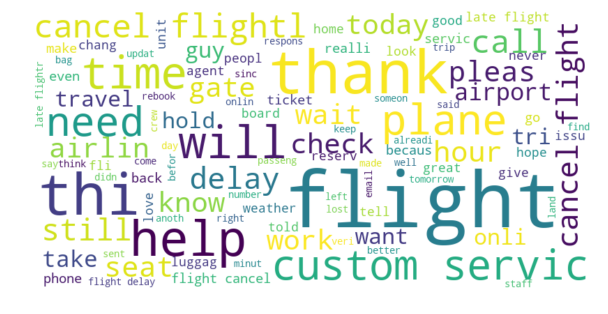

In [272]:
all_words = ' '.join([text for text in data_df['processed_text']])
wordcloud = WordCloud(width=800, height=400, random_state=21, max_words=100, max_font_size=110, background_color="white").generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Most common words for ' + airline)
plt.axis('off')
plt.show()

-> We see that most words convey a neutral sentiment, with 'flight' and 'thank' being most frequent.

##### 3.1.2 Most common words for positive tweets

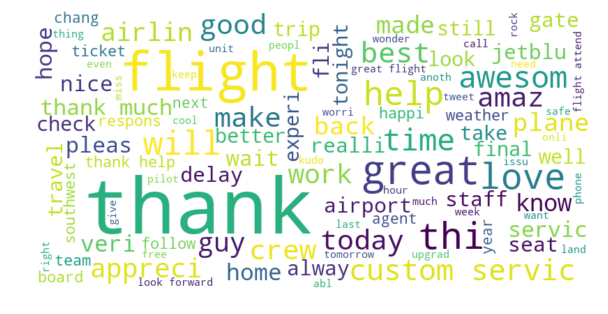

In [273]:
all_words = ' '.join([text for text in data_df['processed_text'][data_df['airline_sentiment']=='positive']])
wordcloud = WordCloud(width=800, height=400, random_state=21, max_words=100, max_font_size=110, background_color="white").generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

-> As expected, most words convey a positive sentiment, with happy words such as 'thank', 'great', 'love', 'help' standing out.

##### 3.1.3 Most common words for negative tweets

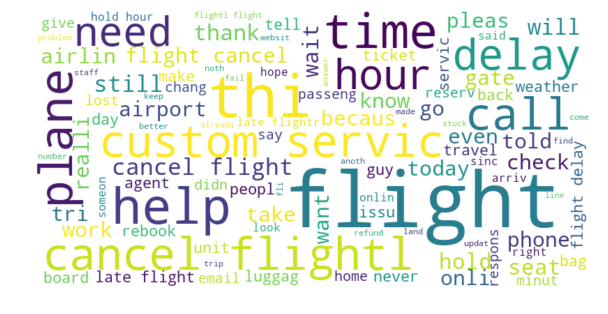

In [274]:
all_words = ' '.join([text for text in data_df['processed_text'][data_df['airline_sentiment']=='negative']])
wordcloud = WordCloud(width=800, height=400, random_state=21, max_words=100, max_font_size=110, background_color="white").generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

-> Surprisingly, most words don't seem to convey a negative sentiment at a first glance. With a closer look, we do observe unhappy words such as 'cancel', 'late', 'delay', and 'didn (didn't)'.

##### 3.1.4 Most common words by Airline

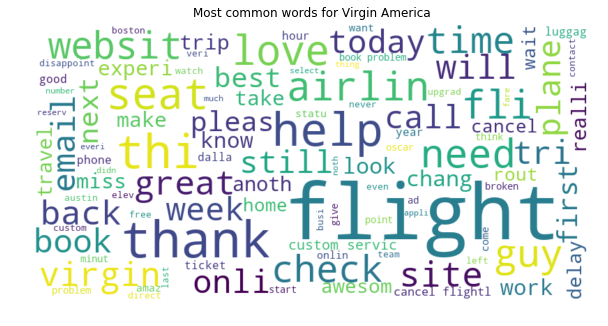

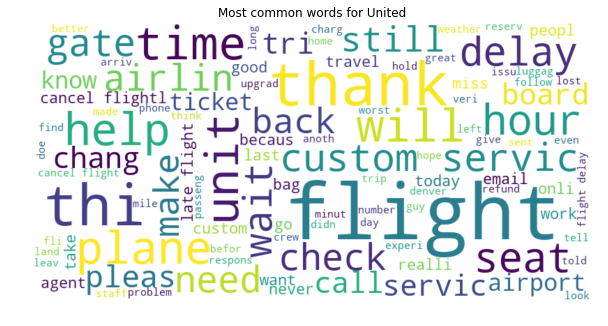

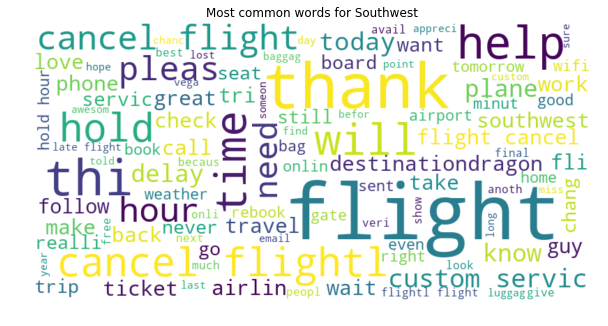

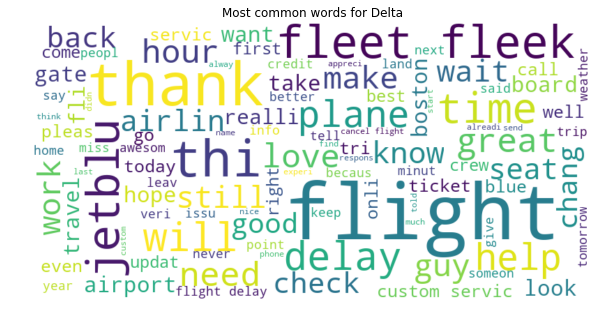

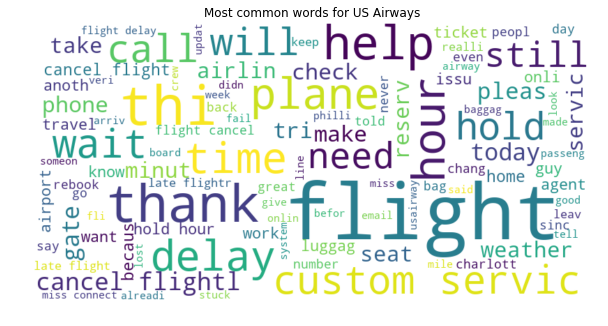

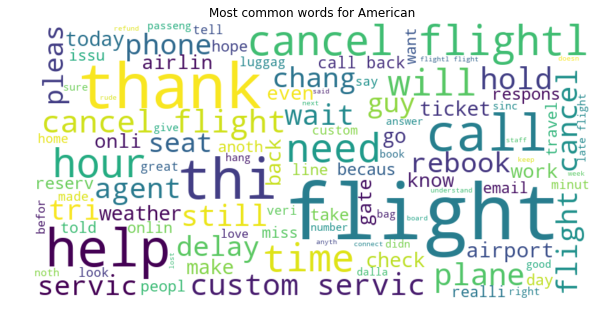

In [275]:
for airline in data_df['airline'].unique():
    all_words = ' '.join([text for text in data_df['processed_text'][data_df['airline']==airline]])
    wordcloud = WordCloud(width=800, height=400, random_state=21, max_words=100, max_font_size=110, background_color="white").generate(all_words)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title('Most common words for ' + airline)
    plt.axis('off')
    plt.show()

-> In general, neutral words appear most frequently for all airlines.

#### 3.2 Impact of hashtags
Let's extract and store hashtags from tweets in two separate lists - one for positive tweets and one for negative tweets.

In [276]:
# Helper function to extract hashtags
def extract_hashtags(text):
    hashtags = []
    # Iterate over words in the tweet
    for word in text:
        extracted_ht = re.findall(r"#(\w+)", word)
        hashtags.append(extracted_ht)
    return hashtags

In [277]:
# Extracting hashtags from positive tweets
hashtags_positive = extract_hashtags(data_df['processed_text'][data_df['airline_sentiment']=='positive'])
# Extracting hashtags from tweets
hashtags_negative = extract_hashtags(data_df['processed_text'][data_df['airline_sentiment']=='negative'])
# Unnest lists
hashtags_positive = sum(hashtags_positive,[])
hashtags_negative = sum(hashtags_negative,[])

Let's plot the top 10 most frequently occuring hashtags for each of positive and negative tweets.

In [278]:
# Helper function to plot bar graph
def top10_hashtags(data, sentiment):
    a = nltk.FreqDist(data)
    b = pd.DataFrame({'hashtag': list(a.keys()), 'count': list(a.values())})   
    b = b.nlargest(columns="count", n = 10) 
    plt.figure(figsize=(15, 5))
    plt.title('Top 10 most frequent hashtags for ' + sentiment + ' tweets')
    ax = sns.barplot(data=b, x= "hashtag", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

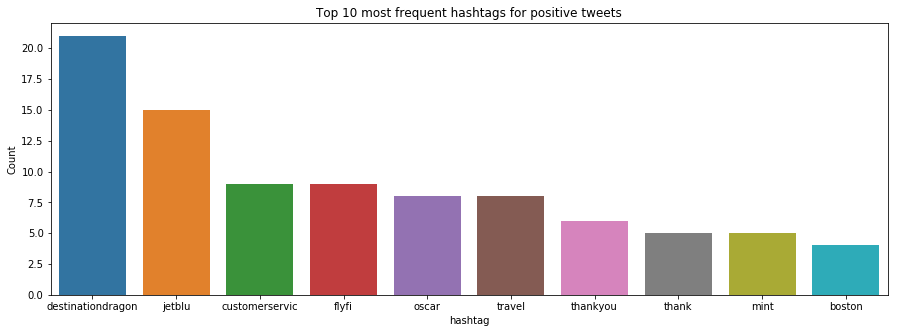

In [279]:
top10_hashtags(hashtags_positive, 'positive')

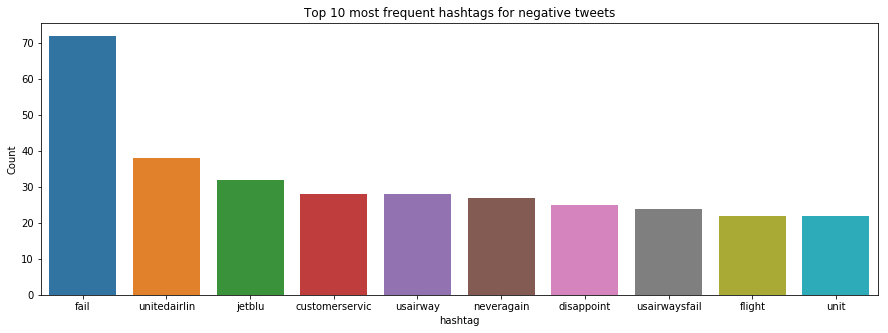

In [280]:
top10_hashtags(hashtags_negative, 'negative')

-> We see that hashtags from negative tweets convey clear negative sentiments: 'fail', 'neveragain', and 'disappoint'. This leads me to wonder, **"are unhappy customers more likely to express their dissatisfaction via hashtags?"**. From this, we know it would be a wise idea to keep hashtags from negative tweets in our dataset as they contain valuable information.

### 4. Transforming tweets into features
We will transform the tweets into features using the **TF-IDF (Term Frequency-Inverse Document Frequency)** technique.
<br/>

Brief description of TF-IDF:
- TF-IDF measures the number of times a word appears in our collection of tweets (term frequency)
- However, the more tweets a word appears in, the less valuable the word is in helping us distinguish between tweets (inverse document frequency)
- Thus, by taking term frequency and inverse documnet frequency into consideration, **TF-IDF aims to identify words that are both frequent AND distintive**

In [281]:
# Exclude neutral tweets
nonneutral_df = data_df[data_df['airline_sentiment']!='neutral']

# Create label column for 'airline_sentiment' such that positive=0 and negative=1
nonneutral_df['airline_sentiment_label'] = np.where(nonneutral_df['airline_sentiment']=='negative', 1, 0)

# Create TF-IDF feature matrix with 1000 features
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(nonneutral_df['processed_text'])

### 5. Building the model
We will build a logistic regression model. Logistic regression is a classificaiton algorithm used to predict a binary outcome - in our case, to predict whether a tweet is a positive (0) or a negative tweet (1). 

In [282]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Split dataset into training and validation set
x_train, x_valid, y_train, y_valid = train_test_split(tfidf_matrix, nonneutral_df['airline_sentiment_label'], random_state=55, test_size=0.3)

# Instantiate Logit model and fit training set
lreg = LogisticRegression()
lreg.fit(x_train, y_train)

# Make prediction on validation set
pred = lreg.predict_proba(x_valid)

# if predicted probability of tweet being a negative-sentiment tweet is greater than or equal to 30%, label as being a negative-sentiment tweet
pred_int = pred[:,1] >= 0.3
pred_int = pred_int.astype(np.int)

# Calculate f1 score
f1_score(y_valid, pred_int)

C:\Users\leejak\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9287051216607113

-> We have an F1-score of 0.93 - almost a perfect score.
</br> 

I'm curious to take a look at some samples of Type-1 and Type- errors:

### 6. Conclusion and next steps...
In this notebook, we explored how to approach a sentiment analysis problem. First, we performed several text preprocessing techniques to clean the tweets. Second, we visualized the tweets and learned that negative tweets are more likely to contain hashtags with negative sentiments than positive tweets. Third, we extracted features from the cleaned tweets using the TF-IDF technique. Finally, we fit the data into a logistic regression model.
<br/>

Ideas for next steps:
- Use the model to perform sentiment analysis on other airline tweets - Korean Air, Emirates, etc...
- Analyze whether sentiments for a particular airline has improved/worsened over time
- Can the `negativereason` variable help us predict whether a negative tweet contains strong or weak negative sentiment?
- Try with other binary classification algorithms - SVM, Random forests, Decision Trees, etc...

### 7. References
- https://kavita-ganesan.com/text-preprocessing-tutorial/#Types-of-text-preprocessing-techniques
- https://www.kaggle.com/crowdflower/twitter-airline-sentiment
- https://www.datacamp.com/community/tutorials/wordcloud-python